In [12]:
import os
import stim
import sinter
import matplotlib.pyplot as plt
import numpy as np

From `getting_started.ipynb` notebook at https://github.com/quantumlib/Stim/blob/main/doc/getting_started.ipynb

In [13]:
noise = 1e-3

surface_code_tasks = [
    sinter.Task(
        circuit = stim.Circuit.generated(
            "surface_code:rotated_memory_z",
            rounds=d * 3,
            distance=d,
            after_clifford_depolarization=noise,
            after_reset_flip_probability=noise,
            before_measure_flip_probability=noise,
            before_round_data_depolarization=noise,
        ),
        json_metadata={'d': d, 'r': d * 3, 'p': noise},
    )
    for d in [3, 5, 7, 9]
]

collected_surface_code_stats: list[sinter.TaskStats] = sinter.collect(
    num_workers=os.cpu_count(),
    tasks=surface_code_tasks,
    decoders=['pymatching'],
    max_shots=5_000_000,
    max_errors=100,
    print_progress=True,
)

Starting 10 workers...
4 tasks left:
  workers    decoder eta shots_left errors_left json_metadata   
        3 pymatching <1m    4990511          80 d=3,r=9,p=0.001 
        3 pymatching   ?    5000000         100 d=5,r=15,p=0.001
        2 pymatching   ?    5000000         100 d=7,r=21,p=0.001
        2 pymatching   ?    5000000         100 d=9,r=27,p=0.001
3 tasks left:
  workers    decoder eta shots_left errors_left json_metadata   
        3 pymatching <1m    4922381          56 d=5,r=15,p=0.001
        3 pymatching <1m    4971533         100 d=7,r=21,p=0.001
        4 pymatching <1m    4988668         100 d=9,r=27,p=0.001
3 tasks left:
  workers    decoder eta shots_left errors_left json_metadata   
        3 pymatching <1m    4851725          27 d=5,r=15,p=0.001
        3 pymatching <1m    4924429          97 d=7,r=21,p=0.001
        4 pymatching <1m    4963068         100 d=9,r=27,p=0.001
2 tasks left:
  workers    decoder eta shots_left errors_left json_metadata   
        5 p

In [14]:
import scipy.stats

# Compute the line fit.
xs = []
ys = []
log_ys = []
for stats in collected_surface_code_stats:
    d = stats.json_metadata['d']
    if not stats.errors:
        print(f"Didn't see any errors for d={d}")
        continue
    per_shot = stats.errors / stats.shots
    per_round = sinter.shot_error_rate_to_piece_error_rate(per_shot, pieces=stats.json_metadata['r'])
    xs.append(d)
    ys.append(per_round)
    log_ys.append(np.log(per_round))
fit = scipy.stats.linregress(xs, log_ys)
print(fit)

LinregressResult(slope=-1.136266866379622, intercept=-4.8546745805291796, rvalue=-0.9989515287028381, pvalue=0.0010484712971619015, stderr=0.03682140311463089, intercept_stderr=0.23577201873957843)


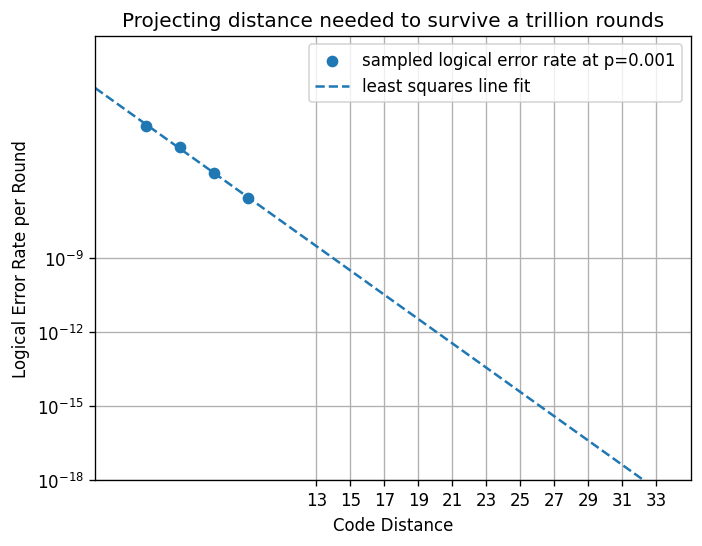

In [15]:
fig, ax = plt.subplots(1, 1)
ax.scatter(xs, ys, label=f"sampled logical error rate at p={noise}")
ax.plot([0, 35],
        [np.exp(fit.intercept), np.exp(fit.intercept + fit.slope * 35)],
        linestyle='--',
        label='least squares line fit')
ax.set_ylim(1e-15, 1e-0)
ax.set_xlim(0, 35)
ax.semilogy()
ax.set_yticks([1e-9, 1e-12, 1e-15, 1e-18])
ax.set_xticks(list(range(13, 35, 2)))
ax.set_title("Projecting distance needed to survive a trillion rounds")
ax.set_xlabel("Code Distance")
ax.set_ylabel("Logical Error Rate per Round")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120)  # Show it bigger

gigaquop => 15

teraquop => 21

petaquop => 27

# What if a better decoder makes LER 4x lower?

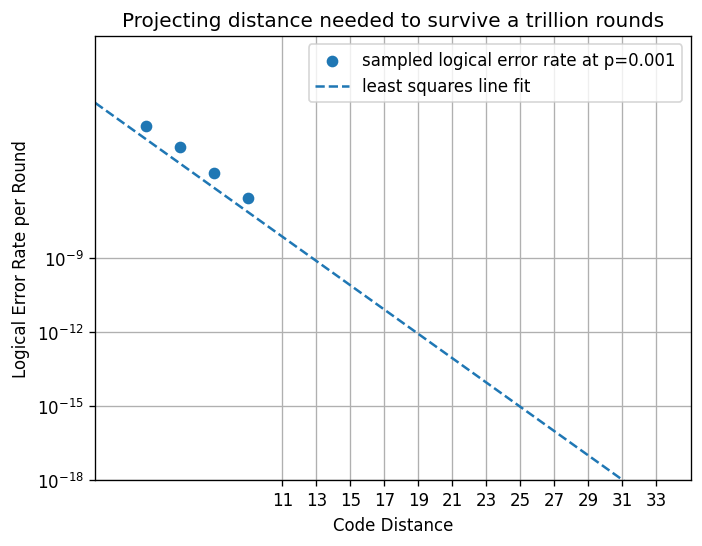

In [17]:
fig, ax = plt.subplots(1, 1)
ax.scatter(xs, ys, label=f"sampled logical error rate at p={noise}")
ax.plot([0, 35],
        [1/4*np.exp(fit.intercept), 1/4*np.exp(fit.intercept + fit.slope * 35)],
        linestyle='--',
        label='least squares line fit')
ax.set_ylim(1e-15, 1e-0)
ax.set_xlim(0, 35)
ax.semilogy()
ax.set_yticks([1e-9, 1e-12, 1e-15, 1e-18])
ax.set_xticks(list(range(11, 35, 2)))
ax.set_title("Projecting distance needed to survive a trillion rounds")
ax.set_xlabel("Code Distance")
ax.set_ylabel("Logical Error Rate per Round")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120)  # Show it bigger

gigaquop => 13

teraquop => 19

petaquop => 25